<a href="https://colab.research.google.com/github/paulhigazi/hello-world/blob/master/softmax_kodiert%2C_aux_seg%2C_multilabel_als_kodierung_f%C3%BCr_Bildgenerierung%2C_mit_augmentierung_und_cross_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla T4, 418.67, 15079 MiB


In [ ]:
## Imports
%tensorflow_version 2.x
import os
import sys
import random
import keras

import copy 

import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np

import imgaug as ia
import imgaug.augmenters as iaa

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

!pip install six numpy scipy Pillow matplotlib scikit-image opencv-python imageio Shapely
!pip install git+https://github.com/aleju/imgaug.git

from google.colab import drive
drive.mount('/gdrive')
 	
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-7auqw8hb
  Running command git clone -q https://github.com/aleju/imgaug.git /tmp/pip-req-build-7auqw8hb
  Created wheel for imgaug: filename=imgaug-0.4.0-cp36-none-any.whl size=971107 sha256=45119b1b335a26ae4c7e2d09fbbbfd2bd655942b02ea073482b12d05da306fe8
  Stored in directory: /tmp/pip-ephem-wheel-cache-by2ws82i/wheels/65/3d/94/ee32cbeaa29c473a4db74c2d21904ac747311fdca4732665f0
Successfully built imgaug
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-8icolehi
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-8icolehi
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=716fc72f57fd72e0d8fd292e515c2b6de1b3bc38b80d7e04e21b47865d85ec83
  Stored in directory: /tmp/pip-ephem-w

In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids1,ids2, path1,path2,path3,format1,format2,format3, batch_size=3, image_size=128,image_size_real=128):
        self.ids1 = ids1
        self.ids2 = ids2
        self.path1=path1
        self.path2=path2
        self.path3=path3
        self.format1=format1
        self.format2=format2
        self.format3=format3
        self.batch_size = batch_size
        self.image_size = image_size
        self.image_size_real=image_size_real
        self.on_epoch_end()
        
    def __load__(self, id_name1,id_name2):

        ## 
        #image_path = os.path.join(self.path1, self.filename1,str(id_number)) + str(format1)
        #mask_path = os.path.join(self.path2,, id_name)+ str(format2)

        image_path = os.path.join(self.path1, id_name1) + "."+str(self.format1)
        mask_path = os.path.join(self.path2, id_name2)+ "."+str(self.format2)

        gt_path=os.path.join(self.path3, id_name2)+ "."+str(self.format3)

        self.image_size=1024

        img_size=self.image_size_real

        if img_size>1023:
          diff=img_size-1023
          low_bound=1023-(diff+1)
        else:
          low_bound=img_size

        h=np.random.randint(low=low_bound, high=1023)
        w=h-np.random.randint(low=0, high=int(0.5*h))

        y=np.random.randint(low=0, high=1023-h)
        x=np.random.randint(low=0, high=1023-w)

        sclaing=np.random.randint(low=128, high=1024)
        randd=0.1

        # Load images from paths and ids
        gt= cv2.imread(gt_path, 0)
        gt = cv2.resize(gt, (self.image_size, self.image_size))
        if randd < 0.5:
          gt = cv2.resize(gt, (sclaing, sclaing))
          gt = cv2.resize(gt, (self.image_size, self.image_size))
        gt=gt[y:y+h, x:x+w]
        gt = cv2.resize(gt, (img_size, img_size))
        gt=np.array(gt,dtype=np.bool)

        mask= cv2.imread(mask_path, 1)
        mask = cv2.resize(mask, (self.image_size, self.image_size))
        if randd < 0.5:
          mask = cv2.resize(mask, (sclaing, sclaing))
          mask = cv2.resize(mask, (self.image_size, self.image_size))
        mask=mask[y:y+h, x:x+w]
        mask = cv2.resize(mask, (img_size, img_size))
        mask=cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        mask=np.array(mask,dtype=np.uint8)

        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        if randd < 0.5:
          image = cv2.resize(image, (sclaing, sclaing))
          image = cv2.resize(image, (self.image_size, self.image_size))
        image=image[y:y+h, x:x+w]
        image = cv2.resize(image, (img_size, img_size))
        image=np.array(image,dtype=np.uint8)
        image=cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        ## Normalizaing 
        image = image/255
        mask = mask/255
        
        #image= np.expand_dims(image, axis=-1)
        #mask= np.expand_dims(mask, axis=-1)
        return image, mask,gt

    def  __augment__(self, image,mask,grtr):

        # Standard scenario: You have N=16 RGB-images and additionally one segmentation
        # map per image. You want to augment each image and its heatmaps identically.

        mask=np.array(mask*255,dtype=np.uint8)
        image=np.array(image*255,dtype=np.uint8)
        grtr=np.array(grtr*255,dtype=np.uint8)
        #print(image.shape)



        seq = iaa.Sequential(
            [
             iaa.Sometimes(0.5,iaa.Affine(translate_px=({"x": (-60, 60),"y": (-60, 60)}))),
             iaa.Sometimes(0.5,iaa.Crop(px=(0, 60))),
             iaa.Fliplr(0.5),
             iaa.Flipud(0.5),

             iaa.SomeOf((1,2),[
             iaa.CoarseDropout(p=0.1, size_percent=0.1,per_channel=0.5),
             iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 2), per_channel=0.5),
             iaa.SaltAndPepper(p=0.1,per_channel=0.5),
             iaa.GaussianBlur((0, 2.0)),
             iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
             ]),

             
             #iaa.FrequencyNoiseAlpha(
              #    exponent=(-4, 0),
             #     first=iaa.Multiply((0.5, 1.5), per_channel=True),
              #    second=iaa.LinearContrast((0.5, 1.0))
              #)
            iaa.OneOf([
             #iaa.AddToHueAndSaturation((-20,20), per_channel=True),
             #iaa.Add((-20, 20), per_channel=True), # change brightness of images (by -10 to 10 of original value)
             ])
             ])


        images_aug= seq(images=image)
        segmaps_aug,grtr_aug= seq(images=mask,segmentation_maps=grtr)

        #for i in range(images_aug.shape[0]):
        #  images_aug[i,:,:,:]=cv2.cvtColor(images_aug[i,:,:,:], cv2.COLOR_BGR2HSV)
        #  segmaps_aug[i,:,:,:]=cv2.cvtColor(segmaps_aug[i,:,:,:], cv2.COLOR_BGR2HSV)



        return images_aug/255, segmaps_aug/255,grtr_aug/255

    def LBP(self,image):
        # import the necessary packages
        from skimage import feature
        import numpy as np

        radius = 1
        n_points = 255

        class LocalBinaryPatterns:
          def __init__(self, numPoints, radius):
            # store the number of points and radius
            self.numPoints = numPoints
            self.radius = radius
          def describe(self, image, eps=1e-7):
            # compute the Local Binary Pattern representation
            # of the image, and then use the LBP representation
            # to build the histogram of patterns
            image=np.asarray(image,dtype=np.uint8)
            image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            lbp = feature.local_binary_pattern(image, self.numPoints,
              self.radius, method="uniform")
            (hist, _) = np.histogram(lbp.ravel(),
              bins=np.arange(0, self.numPoints + 3),
              range=(0, self.numPoints + 2))
            # normalize the histogram
            hist = hist.astype("float")
            hist /= (hist.sum() + eps)
            # return the histogram of Local Binary Patterns
            lbp=lbp/np.max(lbp)
            return hist,lbp

        test=LocalBinaryPatterns(n_points,radius)
        hist,lbp=test.describe(image)
        lbp=np.expand_dims(lbp,axis=-1)
        return (lbp)


    def __getitem__(self):
        
        files_batch1 = random.sample(self.ids1, self.batch_size)
        files_batch2 = random.sample(self.ids2, self.batch_size)
        
        image = []
        mask  = []
        groundt=[]
        
        for counter in range(len(files_batch1)):
            id_name1=files_batch1[counter]
            id_name1=id_name1[:-4]

            id_name2=files_batch2[counter]
            id_name2=id_name2[:-4]

            _img, _mask,gt = self.__load__(id_name1,id_name2)
            #test=self.LBP(_img)
            #test2=self.LBP(_mask)

            #_img2=np.concatenate((_img,test),axis=2)
            #_mask2=np.concatenate((_mask,test2),axis=2)
            image.append(_img)
            mask.append(_mask)
            groundt.append(gt)


        image = np.array(image)
        mask = np.array(mask)
        grtr=np.array(groundt)
        #image,mask,grtr=self.__augment__(image,mask,grtr)
        
        image=(image*2)-1
        mask =(mask*2)-1
        gg=np.expand_dims(grtr,axis=-1)

        return mask, image,gg


    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [ ]:
image_size = 128

#train_path1 = "/gdrive/My Drive/AF35681_Explantat_E17LAO440_T91_MG_AB_OT4/"
#train_path1 = "/gdrive/My Drive/Leber_AZAN_Zellkern/Mehr Test-Objekte/Images/"
train_path1 = "/gdrive/My Drive/MGA_grün_Explantat/Untitled22/Untitled22/"
#train_path1 = "/gdrive/My Drive/MGA_grün_Explantat/Untitled4/Untitled4/"
train_path2 = "/gdrive/My Drive/MGL_Leber/UNET/Data/Untitled4/"
gt_path2="/gdrive/My Drive/MGL_Leber/UNET/Bindegewebe/"
batch_size = 3

## Training Ids
train_ids = next(os.walk(train_path1))[2]
train_ids2= next(os.walk(train_path2))[2]
gt_ids2= next(os.walk(gt_path2))[2]
## Validation Data Size
val_data_size = 64

# Auswählen der Test Daten
valid_ids=random.sample(train_ids, val_data_size)
#valid_ids2=random.sample(train_ids2, val_data_size)
valid_ids_gt=random.sample(gt_ids2, val_data_size)

#Auswählen der Trainingsadaten
train_ids = list(set(train_ids) - set(valid_ids))
#train_ids2 = list(set(train_ids2) - set(valid_ids2))
gt_ids2 = list(set(gt_ids2) - set(valid_ids_gt))
print(len(gt_ids2))

377


In [ ]:
gen = DataGen(train_ids,gt_ids2, train_path1,train_path2,gt_path2,"jpg","jpg","png", batch_size=batch_size, image_size=image_size)
x, y,grtr= gen.__getitem__()
print(x.shape, y.shape, grtr.shape)

(3, 128, 128, 3) (3, 128, 128, 3) (3, 128, 128, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 128, 128, 3)
0.03529411764705892
1.0


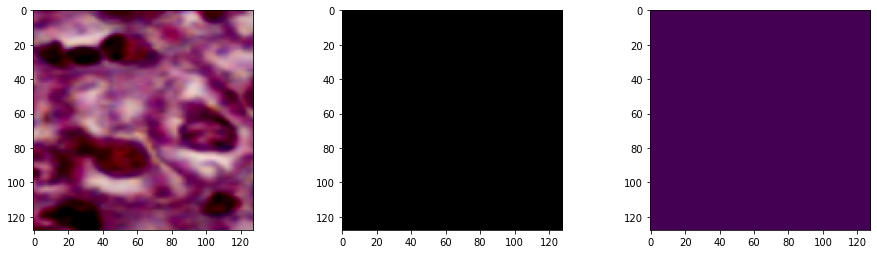

In [ ]:
r = random.randint(0, len(x)-1)
#x=(x+0.5)
#y=(y+0.5)
print(x.shape)
print(np.max(y))
print(np.max(x))
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 3, 1)
ax.imshow(x[r,:,:,:])
ax = fig.add_subplot(1, 3, 2)
ax.imshow(y[r,:,:,:])
ax = fig.add_subplot(1, 3, 3)
ax.imshow(grtr[r,:,:,0])

In [ ]:
import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Lambda
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
import tensorflow.keras.backend as K
from tensorflow.keras.constraints import Constraint
import tensorflow_addons as tfa
from matplotlib import pyplot
from tensorflow_addons.layers import InstanceNormalization as InstanceNormalization

In [ ]:
gen_train = DataGen(train_ids,gt_ids2, train_path1,train_path2,gt_path2,"jpg","jpg","png", batch_size=batch_size, image_size=image_size)
val2_train = DataGen(valid_ids,valid_ids_gt, train_path1,train_path2,gt_path2,"jpg","jpg","png", batch_size=batch_size, image_size=image_size)
val_train = DataGen(valid_ids,valid_ids_gt, train_path1,train_path2,gt_path2,"jpg","jpg","png", batch_size=batch_size, image_size_real=256)

In [ ]:
# generator a resnet block
def se_block(n_filters,ratio,input_layer):
  x=tf.keras.layers.GlobalAveragePooling2D()(input_layer)
  x=tf.keras.layers.Dense(n_filters//ratio)(x)
  x = LeakyReLU(alpha=0.2)(x)
  x=tf.keras.layers.Dense(n_filters)(x)
  x = LeakyReLU(alpha=0.2)(x)
  x=tf.keras.layers.Dense(n_filters)(x)
  x = tf.keras.activations.sigmoid(x)

  return tf.keras.layers.multiply([input_layer,x])

In [ ]:
# generator a resnet block
def resnet_block(n_filters, input_layer):
  # weight initialization
  init =  keras.initializers.RandomNormal(stddev=0.02)
  # first layer convolutional layer
  g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
  g = InstanceNormalization(axis=-1)(g)
  g = LeakyReLU(alpha=0.2)(g)
#  g=se_block(n_filters,1,g)

  # second convolutional layer
  g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = LeakyReLU(alpha=0.2)(g)
#  g=se_block(n_filters,1,g)
  # concatenate merge channel-wise with input layer
  g = Concatenate()([g, input_layer])
  return g

In [ ]:
def shared_core(image_shape, n_resnet=1):

  init =  keras.initializers.RandomNormal(stddev=0.02)
  in_image = Input(shape=image_shape)
  g = resnet_block(256, in_image)
  for _ in range(n_resnet):
    g = resnet_block(256, g)
    g=keras.layers.GaussianNoise(0.1)(g)
  
  model = Model(in_image, g)
  return model

core0=shared_core([None,None,512])
core1=shared_core([None,None,512])
core2=shared_core([None,None,512])

core00=shared_core([None,None,512])
core11=shared_core([None,None,512])
core22=shared_core([None,None,512])

core4=shared_core([None,None,512])
core5=shared_core([None,None,512])
core_CNN=shared_core([None,None,1536])

In [ ]:
# generator a resnet block

def binary_activation(x):

    cond = tf.less(x, 0.51*tf.ones(tf.shape(x)))
    out = tf.where(cond, tf.zeros(tf.shape(x)), tf.ones(tf.shape(x)))

    return out

def binary_activation2(x):

    c = tf.reduce_max(x,axis=-1,keepdims=True)

    cond = tf.less(x, c)
    out = tf.where(cond, tf.zeros(tf.shape(x)), tf.ones(tf.shape(x)))

    return out

def resnet_block_slim_extra(n_filters, input_layer,kernel=3):
  # weight initialization
  init =  keras.initializers.RandomNormal(stddev=0.02)
  # first layer convolutional layer
  g = Conv2D(int(n_filters), (kernel,kernel), padding='same', kernel_initializer=init)(input_layer)
  g = InstanceNormalization(axis=-1)(g)
  g1 = LeakyReLU(alpha=0.2)(g)


  g = Concatenate()([g1, input_layer])
  return g

def resnet_block_slim(n_filters, input_layer,kernel=3):
  # weight initialization
  init =  keras.initializers.RandomNormal(stddev=0.02)
  # first layer convolutional layer
  g = Conv2D(int(n_filters/2), (kernel,kernel), padding='same', kernel_initializer=init)(input_layer)
  g = InstanceNormalization(axis=-1)(g)
  g1 = LeakyReLU(alpha=0.2)(g)


  g = Concatenate()([g1, input_layer])
  return g

# generator a resnet block
def Down_resnet_block(n_filters, input_layer):
  init =  keras.initializers.RandomNormal(stddev=0.02)

  g0 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(input_layer)

  g = Conv2D(int(n_filters/2), (3,3), strides=(2,2), padding='same', kernel_initializer=init)(input_layer)
  g = InstanceNormalization(axis=-1)(g)
  g1 = LeakyReLU(alpha=0.2)(g)

  g = Concatenate()([g1, g0])
  return g

def Up_resnet_block(n_filters, input_layer):
  init =  keras.initializers.RandomNormal(stddev=0.02)

  g0 = tf.keras.layers.UpSampling2D(size=(2, 2))(input_layer)

  g = Conv2DTranspose(int(n_filters/2), (3,3), strides=(2,2), padding='same', kernel_initializer=init)(input_layer)
  g = InstanceNormalization(axis=-1)(g)
  g1 = LeakyReLU(alpha=0.2)(g)

  g = Concatenate()([g1, g0])
  return g

# generator a resnet block
def Sub_AE(stufen,n_filters, input_layer):
  init =  keras.initializers.RandomNormal(stddev=0.02)

  g0 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(input_layer)
  for _ in range(stufen):
    g0 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(g0)

  for _ in range(stufen):
    g0 = tf.keras.layers.UpSampling2D(size=(2, 2))(g0)
  g0 = tf.keras.layers.UpSampling2D(size=(2, 2))(g0)

  return g0



def shared_core_slim(image_shape, n_resnet=1):

  init =  keras.initializers.RandomNormal(stddev=0.02)
  in_image = Input(shape=image_shape)
  g = resnet_block_slim(256, in_image)
  for _ in range(n_resnet):
    g = resnet_block_slim(256, g)
    g=keras.layers.GaussianNoise(0.1)(g)
  
  model = Model(in_image, g)
  return model

core0=shared_core_slim([None,None,544])
core1=shared_core_slim([None,None,544])
core2=shared_core_slim([None,None,544])

core00=shared_core_slim([None,None,544])
core11=shared_core_slim([None,None,544])
core22=shared_core_slim([None,None,544])
core55=shared_core_slim([None,None,544])

def Lang_Gen(image_shape=[None,None,5]):

  init =  keras.initializers.RandomNormal(stddev=0.02)
  in_image = Input(shape=image_shape)

  # c7s1-64
  g = resnet_block_slim_extra(59,in_image,kernel=3)
  g = resnet_block_slim(64,g,kernel=3) # 96
  g=keras.layers.GaussianNoise(0.1)(g)
  g = InstanceNormalization(axis=-1)(g)
  c1 = LeakyReLU(alpha=0.2)(g)

  # d128
  g = Down_resnet_block(128,c1) # 160
  g=keras.layers.GaussianNoise(0.1)(g)
  g = InstanceNormalization(axis=-1)(g)
  c2 = LeakyReLU(alpha=0.2)(g)

  # d256
  g = Down_resnet_block(256,c2) #288
  g=keras.layers.GaussianNoise(0.1)(g)
  g = InstanceNormalization(axis=-1)(g)
  c3 = LeakyReLU(alpha=0.2)(g)


  # d256
  g =  Down_resnet_block(512,c3)# 544
  g=keras.layers.GaussianNoise(0.1)(g)
  g = InstanceNormalization(axis=-1)(g)
  c4 =LeakyReLU(alpha=0.2)(g)

  model = Model(in_image, [c1,c2,c3,c4])
  model.compile(loss="MSE", optimizer="adam")
  return model

def Lang(image_shape=[None,None,3]):

  init =  keras.initializers.RandomNormal(stddev=0.02)
  in_image = Input(shape=image_shape)

  # c7s1-64
  g = resnet_block_slim_extra(61,in_image,kernel=3)
  g = resnet_block_slim(64,g,kernel=3) # 96
  g=keras.layers.GaussianNoise(0.1)(g)
  g = InstanceNormalization(axis=-1)(g)
  c1 = LeakyReLU(alpha=0.2)(g)

  # d128
  g = Down_resnet_block(128,c1) # 160
  g=keras.layers.GaussianNoise(0.1)(g)
  g = InstanceNormalization(axis=-1)(g)
  c2 = LeakyReLU(alpha=0.2)(g)

  # d256
  g = Down_resnet_block(256,c2) #288
  g=keras.layers.GaussianNoise(0.1)(g)
  g = InstanceNormalization(axis=-1)(g)
  c3 = LeakyReLU(alpha=0.2)(g)


  # d256
  g =  Down_resnet_block(512,c3)# 544
  g=keras.layers.GaussianNoise(0.1)(g)
  g = InstanceNormalization(axis=-1)(g)
  c4 =LeakyReLU(alpha=0.2)(g)

  model = Model(in_image, [c1,c2,c3,c4])
  model.compile(loss="MSE", optimizer="adam")
  return model

def Mittel(core,filter=64):
  init =  keras.initializers.RandomNormal(stddev=0.02)

  filter2 = int(filter+filter*0.5) #96
  filter3 = int(filter2+filter) # 96 + 64 = 160
  filter4 = int(filter3+filter*2) # 160 +128 = 288 
  filter5 = int(filter4+filter*4) # 288 + 256 = 544

  c1 = Input(shape=[None,None,int(filter2)])
  c2 = Input(shape=[None,None,int(filter3)])
  c3 = Input(shape=[None,None,int(filter4)])
  c4 = Input(shape=[None,None,int(filter5)])


  c11=resnet_block_slim(64, c1) # 96+32 = 128
#  c11=Sub_AE(2,0, c11)
  c22=resnet_block_slim(128, c2) # 160+64 = 224  
#  c22=Sub_AE(1,0, c22)
  c33=resnet_block_slim(256, c3) # 288 + 128 =  416
#  c33=Sub_AE(0,0, c33)
  c44=resnet_block_slim(512, c4) # 544 + 256 = 800
  gg=core(c4) # 544+128 = 672+128=800

  model = Model([c1,c2,c3,c4], [gg,c11,c22,c33,c44])
  model.compile(loss="MSE", optimizer="adam")
  return model

def Kurz():
  init =  keras.initializers.RandomNormal(stddev=0.02)
  c1 = Input(shape=[None,None,128])
  c2 = Input(shape=[None,None,224])
  c3 = Input(shape=[None,None,416])
  c4 = Input(shape=[None,None,800])
  c5 = Input(shape=[None,None,800])

  # u128
  concat = Concatenate()([c5, c4])
  concat=keras.layers.GaussianNoise(0.1)(concat)
  g = Conv2DTranspose(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(concat)
  g = InstanceNormalization(axis=-1)(g)
  g = LeakyReLU(alpha=0.2)(g)

  g0 = tf.keras.layers.UpSampling2D(size=(2, 2))(g)

  # u128
  concat = Concatenate()([g, c3])
  concat=keras.layers.GaussianNoise(0.1)(concat)
  g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(concat)
  g = InstanceNormalization(axis=-1)(g)
  g = LeakyReLU(alpha=0.2)(g)


  # u64
  concat = Concatenate()([g,g0, c2])
  concat=keras.layers.GaussianNoise(0.1)(concat)
  g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(concat)
  g = InstanceNormalization(axis=-1)(g)
  g = LeakyReLU(alpha=0.2)(g)

  # c7s1-3
  concat = Concatenate()([g, c1])
  concat=keras.layers.GaussianNoise(0.1)(concat)
  g = Conv2D(32, (3,3), padding='same', kernel_initializer=init)(concat)
  g = InstanceNormalization(axis=-1)(g)
  g = LeakyReLU(alpha=0.2)(g)


  gg = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
  out_image = Activation('tanh')(gg)
  
  model = Model([c5,c1,c2,c3,c4], out_image)
  model.compile(loss="MSE", optimizer="adam")

  return model

def Kurz_CNN():
  init =  keras.initializers.RandomNormal(stddev=0.02)
  c1 = Input(shape=[None,None,128])
  c2 = Input(shape=[None,None,224])
  c3 = Input(shape=[None,None,416])
  c4 = Input(shape=[None,None,800])
  c5 = Input(shape=[None,None,800])
  
  # u128
  concat = Concatenate()([c5, c4])
  concat=keras.layers.GaussianNoise(0.1)(concat)
  g = Conv2DTranspose(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(concat)
  g = InstanceNormalization(axis=-1)(g)
  g = LeakyReLU(alpha=0.2)(g)

  g0 = tf.keras.layers.UpSampling2D(size=(2, 2))(g)

  # u128
  concat = Concatenate()([g, c3])
  concat=keras.layers.GaussianNoise(0.1)(concat)
  g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(concat)
  g = InstanceNormalization(axis=-1)(g)
  g = LeakyReLU(alpha=0.2)(g)


  # u64
  concat = Concatenate()([g,g0, c2])
  concat=keras.layers.GaussianNoise(0.1)(concat)
  g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(concat)
  g = InstanceNormalization(axis=-1)(g)
  g = LeakyReLU(alpha=0.2)(g)

  # c7s1-3
  concat = Concatenate()([g, c1])
  concat=keras.layers.GaussianNoise(0.1)(concat)
  g = Conv2D(32, (3,3), padding='same', kernel_initializer=init)(concat)
  g = InstanceNormalization(axis=-1)(g)
  g = LeakyReLU(alpha=0.2)(g)

  gg = Conv2D(5, (7,7), padding='same', kernel_initializer=init)(g)
  out_image1 = Activation('softmax')(gg)
  out_image2 = binary_activation2(out_image1)


  model = Model([c5,c1,c2,c3,c4], [out_image1,out_image2])
  model.compile(loss="binary_crossentropy", optimizer="adam")

  return model

def Kurz_AUX_CNN():
  init =  keras.initializers.RandomNormal(stddev=0.02)
  c1 = Input(shape=[None,None,128])
  c2 = Input(shape=[None,None,224])
  c3 = Input(shape=[None,None,416])
  c4 = Input(shape=[None,None,800])
  c5 = Input(shape=[None,None,800])
  
  # u128
  concat = Concatenate()([c5, c4])
  concat=keras.layers.GaussianNoise(0.1)(concat)
  g = Conv2DTranspose(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(concat)
  g = InstanceNormalization(axis=-1)(g)
  g = LeakyReLU(alpha=0.2)(g)

  g0 = tf.keras.layers.UpSampling2D(size=(2, 2))(g)

  # u128
  concat = Concatenate()([g, c3])
  concat=keras.layers.GaussianNoise(0.1)(concat)
  g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(concat)
  g = InstanceNormalization(axis=-1)(g)
  g = LeakyReLU(alpha=0.2)(g)


  # u64
  concat = Concatenate()([g,g0, c2])
  concat=keras.layers.GaussianNoise(0.1)(concat)
  g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(concat)
  g = InstanceNormalization(axis=-1)(g)
  g = LeakyReLU(alpha=0.2)(g)

  # c7s1-3
  concat = Concatenate()([g, c1])
  concat=keras.layers.GaussianNoise(0.1)(concat)
  g = Conv2D(32, (3,3), padding='same', kernel_initializer=init)(concat)
  g = InstanceNormalization(axis=-1)(g)
  g = LeakyReLU(alpha=0.2)(g)

  gg = Conv2D(5, (7,7), padding='same', kernel_initializer=init)(g)
  out_image1 = Activation('softmax')(gg)


  model = Model([c5,c1,c2,c3,c4], out_image1)
  model.compile(loss="binary_crossentropy", optimizer="adam")

  return model

# Generator 
L1G = Lang_Gen()
M1A = Mittel(core0)
K1A = Kurz()

# Disc
L2B = Lang()
M2B = Mittel(core11)
K2B = Kurz_CNN()

# CNN_self_train
LSCNN = Lang()
MSCNN = Mittel(core22)
KSCNN = Kurz_AUX_CNN()

# CNN
L1A = Lang()
MCNN = Mittel(core55)
KCNN = Kurz_CNN()


# Überschuss
K4B = Kurz()
K5B = Kurz()

L1B = Lang()
M1B = Mittel(core00)
K1B = Kurz()



z = KCNN.predict(MCNN.predict(L1A.predict(x)))

In [ ]:
def encoder(image_shape,core,trainablity=True):
  # weight initialization
  core.trainable=trainablity
  init =  keras.initializers.RandomNormal(stddev=0.02)
  # image input
  in_image = Input(shape=image_shape)
  # c7s1-64
  g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
  g=keras.layers.GaussianNoise(0.1)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = LeakyReLU(alpha=0.2)(g)
  c1=resnet_block(64, g)
  g=keras.layers.GaussianNoise(0.1)(c1)
  # d128
  g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(c1)
  g=keras.layers.GaussianNoise(0.1)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = LeakyReLU(alpha=0.2)(g)
  c2=resnet_block(128, g)
  g=keras.layers.GaussianNoise(0.1)(c2)
  # d256
  g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(c2)
  g=keras.layers.GaussianNoise(0.1)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = LeakyReLU(alpha=0.2)(g)
  c3=resnet_block(256, g)
  g=keras.layers.GaussianNoise(0.1)(c3)

  # d256
  g = Conv2D(512, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(c3)
  g=keras.layers.GaussianNoise(0.1)(g)
  g = InstanceNormalization(axis=-1)(g)
  c4 =LeakyReLU(alpha=0.2)(g)
  g=keras.layers.GaussianNoise(0.1)(c4)

  # R256
  g=core(c4)
  model = Model(in_image, [g,c1,c2,c3,c4])
  return model

image_shape = [image_size,image_size,3]

ecnoder_CNN=encoder(image_shape,core5)

In [ ]:
def define_generator(Lang,Mittel,Kurz,image_shape=[None,None,5]):
	in_image = Input(shape=image_shape)
	
	Lang.trainable=True
	Mittel.trainable=True
	Kurz.trainable=True

	L1 = Lang(in_image)
	M1 = Mittel(L1)
	K1 = Kurz(M1)

	model = Model(in_image, K1)	
	return model

z = KCNN.predict(MCNN.predict(L1A.predict(x)))
t = define_generator(L1G,M1A,K1A).predict(z)


In [ ]:
def define_disc(Lang,Mittel,Kurz,image_shape=[None,None,3]):
  in_image = Input(shape=image_shape)

  Lang.trainable=True
  Mittel.trainable=True
  Kurz.trainable=True

  L1 = Lang(in_image)
  M1 = Mittel(L1)
  K1 = Kurz(M1)

  model = Model(in_image, K1)	
  model.compile(loss="binary_crossentropy", optimizer="adam")
  return model

t = define_disc(L2B,M2B,K2B).predict(x[:,:,:,:])

In [ ]:
# define the standalone generator model
def define_CNN(image_shape, encode,bonus_core):
	in_image = Input(shape=image_shape)
	init =  keras.initializers.RandomNormal(stddev=0.02)
	encode.trainable=True
	bonus_core.trainable=True
 
	g,c1,c2,c3,c4=encode(in_image)


	# u128
	concat = Concatenate()([g, c4])
	concat=keras.layers.GaussianNoise(0.1)(concat)
	g = Conv2DTranspose(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(concat)
	g = InstanceNormalization(axis=-1)(g)
	g = LeakyReLU(alpha=0.2)(g)
	# u128
	concat = Concatenate()([g, c3])
	concat=keras.layers.GaussianNoise(0.1)(concat)
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(concat)
	g = InstanceNormalization(axis=-1)(g)
	g = LeakyReLU(alpha=0.2)(g)
	# u64
	concat = Concatenate()([g, c2])
	concat=keras.layers.GaussianNoise(0.1)(concat)
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(concat)
	g = InstanceNormalization(axis=-1)(g)
	g = LeakyReLU(alpha=0.2)(g)
	# c7s1-3
	concat = Concatenate()([g, c1])
	concat=keras.layers.GaussianNoise(0.1)(concat)
	g = Conv2D(1, (7,7), padding='same', kernel_initializer=init)(concat)
	#g = InstanceNormalization(axis=-1)(g)
	#g=keras.layers.BatchNormalization()(g)
	out_image = Activation('sigmoid')(g)
	# define model
	
	model = Model(in_image, out_image)
	model.compile(loss="binary_crossentropy", optimizer="adam")
	return model

In [ ]:
# define the standalone generator model
def define_CNN(image_shape,Kurz,Mittel,Lang):
  in_image = Input(shape=image_shape)
  init =  keras.initializers.RandomNormal(stddev=0.02)

  Kurz.trainable=True  
  Mittel.trainable=True
  Lang.trainable=True

  out_image = Kurz(Mittel(Lang(in_image)))
 
  # define model
	
  model = Model(in_image, out_image)
  model.compile(loss="binary_crossentropy", optimizer="adam")
  return model

Classifier = define_CNN(image_shape,K1A,MCNN,L1A)

In [ ]:
def IID_loss(x_out, x_tf_out, lamb=1.0, EPS=sys.float_info.epsilon):

  x_out=tf.convert_to_tensor(x_out)
  x_tf_out=tf.convert_to_tensor(x_tf_out)

  k =tf.shape(x_out)[-1]
  # skip assertions

  # joint probability
  p = tf.reduce_sum(tf.expand_dims(x_out, 2) * tf.expand_dims(x_tf_out, 1), 0)
  p = (p + tf.transpose(p)) / 2 # symmetry
  p = tf.clip_by_value(p, EPS, 1e9)
  p /= tf.reduce_sum(p) # normalize

  pi = tf.broadcast_to(tf.reshape(tf.reduce_sum(p, axis=0), (k, 1)), (k, k))
  pj = tf.broadcast_to(tf.reshape(tf.reduce_sum(p, axis=1), (1, k)), (k, k))

  iloss = -tf.reduce_sum(p * (tf.math.log(p) - lamb * tf.math.log(pi) - lamb * tf.math.log(pj)))


  return iloss

In [ ]:
def define_discriminator(image_shape,encode):
	in_image = Input(shape=image_shape)
	init =  keras.initializers.RandomNormal(stddev=0.02)
	g,c1,c2,c3,c4=encode(in_image)


	concat = Concatenate()([g, c4])
	concat=keras.layers.GaussianNoise(0.1)(concat)
	g=keras.layers.UpSampling2D()(concat)
	g = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g1 = LeakyReLU(alpha=0.2)(g)

  # u128
	concat = Concatenate()([g1, c3])
	concat=keras.layers.GaussianNoise(0.1)(concat)
	g=keras.layers.UpSampling2D()(concat)
	g = Conv2D(128, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g2 = LeakyReLU(alpha=0.2)(g)

	# u64
	concat = Concatenate()([g2, c2])
	concat=keras.layers.GaussianNoise(0.1)(concat)
	g=keras.layers.UpSampling2D()(concat)
	g = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g3 = LeakyReLU(alpha=0.2)(g)

	# c7s1-3
	concat = Concatenate()([g3, c1])
 
	g = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(concat)
	g = InstanceNormalization(axis=-1)(g)
	g = LeakyReLU(alpha=0.2)(g)


 
	g=keras.layers.GaussianNoise(0.1)(g)
	out_image = Conv2D(1, (7,7), padding='same', kernel_initializer=init)(g)
	out_image = Activation('sigmoid')(out_image)
	model = Model(in_image, out_image)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0004, beta_1=0.5))
	return model

In [ ]:
# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	#g_model_1.load_weights('/content/runde2/g_model_BtoA_000100.h5')
	# mark discriminator as not trainable
	d_model.trainable = True
	# mark other generator model as not trainable
	g_model_2.trainable = False
	#g_model_2.load_weights('/content/runde2/g_model_AtoB_000100.h5')
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
 
	input_gen_aug = Input(shape=image_shape)
	gen1_out_aug = g_model_1(input_gen_aug)

	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)


### AUG
	# identity element
	input_id_aug = Input(shape=image_shape)
	output_id_aug = g_model_1(input_id_aug)
	# forward cycle
	output_f_aug = g_model_2(gen1_out_aug)
	# backward cycle
	gen2_out = g_model_2(input_id_aug)
	output_b_aug = g_model_1(gen2_out)

### similarity matching

	sim_aug_in = Input(shape=image_shape)
	gen1_out_aug = g_model_1(sim_aug_in)
	d_g_out = d_model(gen1_out_aug)

	sim_aug_id = Input(shape=image_shape)
	sim_aug_id_out = g_model_1(sim_aug_id)
	d_id_out = d_model(sim_aug_id_out)

	# define model graph
	model = Model([input_gen,input_gen_aug, input_id,input_id_aug,sim_aug_id,sim_aug_in], [output_id, output_f, output_b,output_id_aug,output_f_aug,output_b_aug,d_id_out,d_g_out])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0001, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=[ 'mse', 'mse', 'mse', 'mse', 'mse', 'mse',"categorical_crossentropy","categorical_crossentropy"], loss_weights=[5, 10, 10,5, 10, 10,1,1], optimizer=opt)
	model.summary()
	return model

In [ ]:
def Stufe_1(Kurz, Mittel, Lang,Kurz2, Mittel2, Lang2, image_shape=[None,None,3]):
	# ensure the model we're updating is trainable
	Kurz.trainable = True
	Mittel.trainable = False
	Lang.trainable = False

#	Kurz2.trainable = False
#	Mittel2.trainable = False
#	Lang2.trainable = False

  # classic forward
	input_gen = Input(shape=image_shape)
	gen1_out = Kurz(Mittel(Lang(input_gen)))
 
	# identity element
	input_id = Input(shape=image_shape)
	output_id = Kurz(Mittel(Lang(input_id)))
 
	id_LM = Mittel(Lang(gen1_out))
	sid_K = Kurz(id_LM)


	# forward cycle
	output_f = Kurz2(Mittel2(Lang2(gen1_out)))
	# backward cycle
	gen2_out = Kurz2(Mittel2(Lang2(input_id)))
	output_b = Kurz(Mittel(Lang(gen2_out)))


	# define model graph
	model = Model([input_gen, input_id], [ output_id,sid_K, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0005, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=[ 'mse', 'mse', 'mse', 'mse'], loss_weights=[5, 5, 10, 10], optimizer=opt)
	model.summary()
	
	model_pred = Model(input_gen, [gen1_out])
 
	return model,model_pred


In [ ]:
def Stufe_2(Kurz, Mittel, Lang,  Kurz3,Kurz4   ,Kurz2, Mittel2, Lang2, image_shape=[None,None,3]):

  Kurz3.trainable = True
  Kurz4.trainable = False

  Kurz.trainable = True
  Mittel.trainable = True
  Lang.trainable = False

#  Kurz2.trainable = False
#  Mittel2.trainable = False
#  Lang2.trainable = False

  # classic forward
  input_gen = Input(shape=image_shape)
  gen1_LM = Mittel(Lang(input_gen))

  gen1_K = Kurz(gen1_LM)
  gen1_K3 = Kurz3(gen1_LM)
  gen1_K4 = Kurz4(gen1_LM)

  # identity element
  input_id = Input(shape=image_shape)
  id_LM = Mittel(Lang(input_id))

  id_K = Kurz(id_LM)
  id_K3 = Kurz3(id_LM)
  id_K4 = Kurz4(id_LM)

  # self identity

  id_LM = Mittel(Lang(gen1_K))
  id_LM3 = Mittel(Lang(gen1_K3))
  id_LM4 = Mittel(Lang(gen1_K4))

  sid_K = Kurz(id_LM)
  sid_K3 = Kurz3(id_LM3)
  sid_K4 = Kurz4(id_LM4) 


  # forward cycle
  output_f = Kurz2(Mittel2(Lang2(gen1_K)))
  output_f3 = Kurz2(Mittel2(Lang2(gen1_K3)))
  output_f4 = Kurz2(Mittel2(Lang2(gen1_K4)))

  # backward cycle
  gen2_out = Kurz2(Mittel2(Lang2(input_id)))
  back_LM = Mittel(Lang(gen2_out))

  b_K = Kurz(back_LM)
  b_K3 = Kurz3(back_LM)
  b_K4 = Kurz4(back_LM)

  # define model graph
  model = Model([input_gen, input_id], [id_K,id_K3,id_K4,   sid_K,sid_K3,sid_K4,    output_f,output_f3,output_f4, b_K,b_K3,b_K4])
  # define optimization algorithm configuration
  opt = Adam(lr=0.00025, beta_1=0.5)
  # compile model with weighting of least squares loss and L1 loss
  model.compile(loss='mse', loss_weights=[ 5,5,5,5,5,5, 10, 10,10, 10,10, 10], optimizer=opt)
  model.summary()
  
  model_pred = Model(input_gen, [gen1_K,gen1_K3,gen1_K4])
  return model,model_pred

In [ ]:
def Stufe_3(Kurz, Mittel, Lang,  Kurz3,Kurz4,Kurz5,  Mittel3,Mittel4  ,Kurz2, Mittel2, Lang2, image_shape=[None,None,3]):

  Kurz3.trainable = True
  Kurz4.trainable = False
  Kurz5.trainable = True

  Kurz.trainable = True
  Mittel.trainable = True
  Lang.trainable = True

  Mittel3.trainable = True
  Mittel4.trainable = False

#  Kurz2.trainable = False
#  Mittel2.trainable = False
#  Lang2.trainable = True

  # identity element
  input_id = Input(shape=image_shape)
  id_LM = Mittel(Lang(input_id))

  id_K1 = Kurz(id_LM)
  id_K13 = Kurz3(id_LM)
  id_K14 = Kurz4(id_LM)
  id_K15 = Kurz5(id_LM)
  
  # M3
  id_LM3 = Mittel3(Lang(input_id))

  id_K3 = Kurz(id_LM3)
  id_K33 = Kurz3(id_LM3)
  id_K43 = Kurz4(id_LM3)
  id_K53 = Kurz5(id_LM3)
  
  # M4
  id_LM4 = Mittel4(Lang(input_id))

  id_K4 = Kurz(id_LM4)
  id_K34 = Kurz3(id_LM4)
  id_K44 = Kurz4(id_LM4)
  id_K54 = Kurz5(id_LM4)

  # classic forward
  input_gen = Input(shape=image_shape)
  gen1_LM = Mittel(Lang(input_gen))

  gen1_K1 = Kurz(gen1_LM)
  gen1_K13 = Kurz3(gen1_LM)
  gen1_K14 = Kurz4(gen1_LM)
  gen1_K15 = Kurz5(gen1_LM)
  
  # M3
  gen1_LM3 = Mittel3(Lang(input_gen))

  gen1_K3 = Kurz(gen1_LM3)
  gen1_K33 = Kurz3(gen1_LM3)
  gen1_K43 = Kurz4(gen1_LM3)
  gen1_K53 = Kurz5(gen1_LM3)
  
  # M4
  gen1_LM4 = Mittel4(Lang(input_gen))

  gen1_K4 = Kurz(gen1_LM4)
  gen1_K34 = Kurz3(gen1_LM4)
  gen1_K44 = Kurz4(gen1_LM4)
  gen1_K54 = Kurz5(gen1_LM4)
  
  # forward cycle

  output_f1 = Kurz2(Mittel2(Lang2(gen1_K1)))
  output_f13 = Kurz2(Mittel2(Lang2(gen1_K13)))
  output_f14 = Kurz2(Mittel2(Lang2(gen1_K14)))
  output_f15 = Kurz2(Mittel2(Lang2(gen1_K15)))

  output_f3 = Kurz2(Mittel2(Lang2(gen1_K3)))
  output_f33 = Kurz2(Mittel2(Lang2(gen1_K33)))
  output_f43 = Kurz2(Mittel2(Lang2(gen1_K43)))
  output_f53 = Kurz2(Mittel2(Lang2(gen1_K53)))

  output_f4 = Kurz2(Mittel2(Lang2(gen1_K4)))
  output_f34 = Kurz2(Mittel2(Lang2(gen1_K34)))
  output_f44 = Kurz2(Mittel2(Lang2(gen1_K44)))
  output_f54 = Kurz2(Mittel2(Lang2(gen1_K54)))

  # backward cycle
  gen2_out = Kurz2(Mittel2(Lang2(input_id)))

  back_LM = Mittel(Lang(gen2_out))

  b_K1 = Kurz(back_LM)
  b_K13 = Kurz3(back_LM)
  b_K14 = Kurz4(back_LM)
  b_K15 = Kurz5(back_LM)

  back_LM3 = Mittel3(Lang(gen2_out))

  b_K3 = Kurz(back_LM3)
  b_K33 = Kurz3(back_LM3)
  b_K43 = Kurz4(back_LM3)
  b_K53 = Kurz5(back_LM3)

  back_LM4 = Mittel4(Lang(gen2_out))

  b_K4 = Kurz(back_LM4)
  b_K34 = Kurz3(back_LM4)
  b_K44 = Kurz4(back_LM4)
  b_K54 = Kurz5(back_LM4)

  # define model graph
  model = Model([input_gen, input_id], [ id_K1,id_K13,id_K14,id_K15,  id_K3,id_K33,id_K43,id_K53,   id_K4,id_K34,id_K44,id_K54    ,output_f1,output_f13,output_f14,output_f15,   output_f3,output_f33,output_f43,output_f53,    output_f4,output_f34,output_f44,output_f54,    b_K1,b_K13,b_K14,b_K15,  b_K3,b_K33,b_K43,b_K53,    b_K4,b_K34,b_K44,b_K54])
  # define optimization algorithm configuration
  opt = Adam(lr=0.0001, beta_1=0.5)
  # compile model with weighting of least squares loss and L1 loss
  model.compile(loss='mse', loss_weights=[ 5,5,5,5,5  ,5,5,5,5,5   ,5,5,5,5,5  ,10,10,10,10,10  ,10,10,10,10,10    ,10,10,10,10,10    ,10,10,10,10,10  ,10,10,10,10,10    ,10,10,10,10,10], optimizer=opt)
  model.summary()
  return model

In [ ]:
def Classify_Gen(Class,Gen, image_shape=[None,None,3],semantic_shape=[None,None,5]):

  # soft = binary

  # classic forward
  input_gen = Input(shape=image_shape)

  # identity element
  input_id = Input(shape=image_shape)

  # semantic element
  semantic = Input(shape=semantic_shape)

  gen_out,gen_out_soft = Class(input_gen)
  id_out,id_out_soft = Class(input_id)

  gen_out_gen  = Gen(gen_out_soft)
  id_out_gen = Gen(id_out_soft)

  gen_out2,gen_out_soft2 = Class(gen_out_gen)
  id_out2,id_out_soft2 = Class(id_out_gen)

  gen_out_gen2  = Gen(gen_out_soft2)
  id_out_gen2 = Gen(id_out_soft2)

  # define model graph
  model = Model([input_gen, input_id, semantic], [gen_out_gen,  id_out_gen,  gen_out_gen2,  id_out_gen2,  gen_out_soft,  id_out_soft,  gen_out_soft2,  id_out_soft2])
  # define optimization algorithm configuration
  opt = Adam(lr=0.002, beta_1=0.5)
  # compile model with weighting of least squares loss and L1 loss
  model.compile(loss=['mse', 'mse','mse', 'mse',"categorical_crossentropy","categorical_crossentropy","categorical_crossentropy","categorical_crossentropy"], loss_weights=[ 10, 10,10, 10,1,1,1,1], optimizer=opt)
  model.summary()
 
  return model


In [ ]:

# example of calculating the frechet inception distance in Keras
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
 
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid
 
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# define two fake collections of images
images1 = randint(0, 255, 10*32*32*3)
images1 = images1.reshape((10,32,32,3))
images2 = randint(0, 255, 10*32*32*3)
images2 = images2.reshape((10,32,32,3))
print('Prepared', images1.shape, images2.shape)
# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
# fid between images1 and images1
fid = calculate_fid(model, images1, images1)
print('FID (same): %.3f' % fid)
# fid between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)

87916544/87910968 [==============================] - 2s 0us/step
Prepared (10, 32, 32, 3) (10, 32, 32, 3)
Scaled (10, 299, 299, 3) (10, 299, 299, 3)
FID (same): -0.000
FID (different): 45.739


In [ ]:
def augmentcolor(images,maske):
	sometimes = lambda aug: iaa.Sometimes(0.5, aug)
	seq = iaa.Sequential(
			[
				iaa.Rotate((-180, 180)),
        iaa.Affine(translate_px=({"x": (-30, 30),"y": (-30, 30)})),
        iaa.CropAndPad(percent=(-0.40, 0.40)),

				iaa.KMeansColorQuantization(n_colors=(5, 256)),
				iaa.OneOf([	
					          sometimes(iaa.MedianBlur((1, 5))),
										sometimes(iaa.AverageBlur((1, 5))),
										sometimes(iaa.GaussianBlur((1, 5)))])

			])
	segmaps_aug,mask_aug= seq(images=images,segmentation_maps=maske)

 
	return ((segmaps_aug/255)*2)-1,mask_aug/255


def augment(image,mask):
	sometimes = lambda aug: iaa.Sometimes(0.5, aug)
	seq = iaa.Sequential(
			[
				iaa.Rotate((-180, 180)),
        iaa.Affine(translate_px=({"x": (-20, 20),"y": (-20, 20)})),
        iaa.CropAndPad(percent=(-0.20, 0.20)),			
		
				iaa.SomeOf((0, 2),[	
										iaa.AddToHueAndSaturation(value_saturation=(-20,20), per_channel=True),
										iaa.Add((-20, 20), per_channel=True),
										iaa.AllChannelsCLAHE(clip_limit=(1, 10)),
										iaa.HistogramEqualization(),
										iaa.Canny(alpha=(0.0, 0.5),colorizer=iaa.RandomColorsBinaryImageColorizer(color_true=255,color_false=0)),

										iaa.Multiply((0.5, 1.5), per_channel=0.5),
										iaa.Sharpen(alpha=(0, 1.0), lightness=(0.1, 1)),

										iaa.Grayscale(alpha=(1.0, 1.0)),
										iaa.LinearContrast((0.5, 1.0)),
										iaa.LogContrast(gain=(0.6, 1.4)),
										iaa.GammaContrast((0.5, 2.0)),
										iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6)),

					          sometimes(iaa.MedianBlur((1, 9))),
										sometimes(iaa.AverageBlur((1, 9))),
										sometimes(iaa.GaussianBlur((1, 9)))

			])])
	segmaps_aug,mask_aug= seq(images=image,segmentation_maps=mask)

 
	return ((segmaps_aug/255)*2)-1,mask_aug/255

def augment2(image,mask):

	mask = np.array(mask*255,dtype=np.uint8)
	image = np.array(image,dtype=np.uint8)
	sometimes = lambda aug: iaa.Sometimes(0.5, aug)
	seq = iaa.Sequential(
			[
				iaa.Rotate((-180, 180)),
        iaa.Affine(translate_px=({"x": (-30, 30),"y": (-30, 30)})),
        iaa.CropAndPad(percent=(-0.40, 0.40)),			
		
				iaa.SomeOf((0, 2),[	
										iaa.AddToHueAndSaturation(value_saturation=(-20,20), per_channel=True),
										iaa.Add((-20, 20), per_channel=True),
										iaa.AllChannelsCLAHE(clip_limit=(1, 10)),
										iaa.HistogramEqualization(),
										iaa.Canny(alpha=(0.0, 0.5),colorizer=iaa.RandomColorsBinaryImageColorizer(color_true=255,color_false=0)),

										iaa.Multiply((0.5, 1.5), per_channel=0.5),
										iaa.Sharpen(alpha=(0, 1.0), lightness=(0.1, 1)),
			]),

				iaa.OneOf([	
										iaa.Grayscale(alpha=(1.0, 1.0)),
										iaa.LinearContrast((0.5, 1.0)),
										iaa.LogContrast(gain=(0.6, 1.4)),
										iaa.GammaContrast((0.5, 2.0)),
										iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6)),

			]),
				iaa.OneOf([	
					          sometimes(iaa.MedianBlur((1, 9))),
										sometimes(iaa.AverageBlur((1, 9))),
										sometimes(iaa.GaussianBlur((1, 9)))])

			])
	segmaps_aug,mask_aug= seq(images=image,segmentation_maps=mask)

 
	return ((segmaps_aug/255)*2)-1,mask_aug/255

def augment_gen_gs(image):
	sometimes = lambda aug: iaa.Sometimes(0.5, aug)
	seq = iaa.Sequential(
			[
				iaa.Grayscale(alpha=(1.0, 1.0))])

	segmaps_aug= seq(images=image)

 
	return ((segmaps_aug/255)*2)-1


def augment_gen(image):
	sometimes = lambda aug: iaa.Sometimes(0.5, aug)
	seq = iaa.Sequential(
			[

				iaa.Add((-1, 1), per_channel=True),


			])
	segmaps_aug= seq(images=image)

 
	return ((segmaps_aug/255)*2)-1

def augment_rot_gen(image):

	image = np.array(image,dtype=np.uint8)

	sometimes = lambda aug: iaa.Sometimes(0.5, aug)
	seq = iaa.Sequential(
			[
				#iaa.Rotate((-180, 180)),
        #iaa.Affine(translate_px=({"x": (-30, 30),"y": (-30, 30)})),
        #iaa.CropAndPad(percent=(-0.40, 0.40)),
				
				iaa.SomeOf((0, 1),[	
										iaa.AddToHueAndSaturation(value_saturation=(-20,20), per_channel=True),
										iaa.Add((-20, 20), per_channel=True),
										iaa.AllChannelsCLAHE(clip_limit=(1, 10)),
										iaa.HistogramEqualization(),
										iaa.Canny(alpha=(0.0, 0.5),colorizer=iaa.RandomColorsBinaryImageColorizer(color_true=255,color_false=0)),

										iaa.Multiply((0.5, 1.5), per_channel=0.5),
										iaa.Sharpen(alpha=(0, 1.0), lightness=(0.1, 1)),

										iaa.Grayscale(alpha=(1.0, 1.0)),
										iaa.LinearContrast((0.5, 1.0)),
										iaa.LogContrast(gain=(0.6, 1.4)),
										iaa.GammaContrast((0.5, 2.0)),
										iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6)),

					          sometimes(iaa.MedianBlur((1, 9))),
										sometimes(iaa.AverageBlur((1, 9))),
										sometimes(iaa.GaussianBlur((1, 9)))])

			])
	segmaps_aug= seq(images=image)

 
	return ((segmaps_aug/255)*2)-1

def generate_real_samples(A,patch_shape,gen_train=gen_train):
	if A==True:
		x, y,gt= gen_train.__getitem__()
		z = np.ones((y.shape[0], patch_shape, patch_shape, 1))
		z=z*0.9
		if random.random() < 0.2:
			z = np.zeros((y.shape[0], patch_shape, patch_shape, 1))
		return x, z,gt
	
	else:
		x, y,gt= gen_train.__getitem__()
		z = np.ones((y.shape[0], patch_shape, patch_shape, 1))
		z=z*0.9
		if random.random() < 0.2:
			z = np.zeros((y.shape[0], patch_shape, patch_shape, 1))
		return y, z,gt

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	y=y*0.1
	if random.random() < 0.2:
		y=ones((len(X), patch_shape, patch_shape, 1))*0.9

	return X, y

# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA,seg):
	# save the first generator model
	filename1 = '/content/runde2/g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = '/content/runde2/g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	# save the second generator model
	filename3 = '/content/runde2/SegModel_%06d.h5' % (step+1)
	seg.save(filename3)
	print('>Saved: %s and %s and %s' % (filename1, filename2,filename3))
 
# generate samples and save as a plot and save the model
def summarize_performance(step, Classifier,Generator,A, name, n_samples=5):
	# select a sample of input images
	X_A, _,gtA = generate_real_samples(True, 0,gen_train=val_train)
	X_B, _,gt = generate_real_samples(False, 0,gen_train=val_train)

	X_B = X_B[:4,:,:,:]
	X_A = X_A[:4,:,:,:]
	n_samples=X_B.shape[0]

	C_B = Classifier.predict(X_B)
	C_A = Classifier.predict(X_A)

	G_B = Generator.predict(C_B)
	G_A = Generator.predict(C_A)
	#GT_A = Generator.predict(gtA)

	G_B = (G_B + 1)/2
	G_A = (G_A+1)/2
	#GT_A = (GT_A + 1)/2

	X_B = (X_B + 1)/2
	X_A = (X_A+1)/2

	for i in range(n_samples):
		pyplot.subplot(4, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_A[i,:,:,:])

	for i in range(n_samples):
		pyplot.subplot(4, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(G_A[i,:,:,:])
	
	for i in range(n_samples):
		pyplot.subplot(4, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_B[i,:,:,:])
	
	for i in range(n_samples):
		pyplot.subplot(4, n_samples, 1 + n_samples*3 + i)
		pyplot.axis('off')
		pyplot.imshow(G_B[i,:,:,:])


		# save plot to file
	filename1 = '/content/runde2/%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1,dpi=200)
	pyplot.close()

# generate samples and save as a plot and save the model
def summarize_seg_performance(step, g_model,g_model2,seg_model,A, name, n_samples=5):
	# select a sample of input images
	X_in, _,gt = generate_real_samples(A, 0,gen_train=val_train)
	X_inB, _,gt = generate_real_samples(False, 0,gen_train=val_train)

	X_in = X_in[:4,:,:,:]
	X_inB = X_inB[:4,:,:,:]

	n_samples=X_in.shape[0]

	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	X_out2, _ = generate_fake_samples(g_model2, X_inB, 0)
	seg_out, _ = generate_fake_samples(seg_model, X_inB, 0)
 	
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_inB + 1)/2
	X_out2 = (X_out2 + 1)/2
	seg_out = seg_out
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i,:,:,:3])
		# plot translated image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 +n_samples+ i)
		pyplot.axis('off')
		pyplot.imshow(X_out2[i,:,:,:3])
		# plot translated image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(seg_out[i,:,:,0])
		# save plot to file
	filename1 = '/content/runde2/%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1,dpi=200)
	pyplot.close()

 # update image pool for fake images
def update_image_pool(pool, images, max_size=2):
  selected = list()
  for image in images:
    if (len(pool)-1) < max_size:
      # stock the pool
      pool.append(image)
      selected.append(image)
    elif random.random() < 0.3:
      # use image, but don't add it to the pool
      selected.append(image)
    else:
      # replace an existing image and use replaced image
      ix = random.randint(0, len(pool)-1)
      selected.append(pool[ix])
      pool[ix] = image
  return asarray(selected)
 
# train cyclegan models
def train(Classifier,Generator,lossg1,lossg2,fidd,fidd2):
	# define properties of the training run
	n_epochs, n_batch, = 100, 1
	# determine the output square shape of the discriminator
	x1, _,_= gen_train.__getitem__()

	z,_ = KCNN.predict(MCNN.predict(L1A.predict(x1)))

	wanna_be_real = np.ones_like(z[0,:,:,:])
	FALSCH = np.zeros_like(z[0,:,:,:])

	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo =  len(train_ids)//batch_size
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	counter=0
	gen2 = DataGen(train_ids,gt_ids2, train_path1,train_path2,gt_path2,"jpg","jpg","png", batch_size=10, image_size=299,image_size_real=256)

	# Aktuell

	for i in range(n_steps):

		wanna_be_real = np.ones_like(z[0,:,:,:])
		FALSCH = np.zeros_like(z[0,:,:,:])
	
		counter=counter+1
		# select a batch of real samples
		X_realA, y_realA ,gt_realA= generate_real_samples(True,6 ) 
		X_realB, y_realB ,gt_realB= generate_real_samples(False,6 ) 

		X_realAA = copy.deepcopy(X_realA)
		X_realBB = copy.deepcopy(X_realB)

		# validation samples
		X_realAv, _ ,_= generate_real_samples(True,6 ,gen_train=val2_train) 
		X_realBv, _ ,_= generate_real_samples(False,6 ,gen_train=val2_train) 
	
		#  relocate	
		imgs = image_size-1
		low_bound=32

		h=np.random.randint(low=low_bound, high=imgs)
		w=h-np.random.randint(low=0, high=int(0.5*h))

		y=np.random.randint(low=0, high=imgs-h)
		x=np.random.randint(low=0, high=imgs-w)

		rand = np.random.uniform()
		if rand > 0.5:
			X_realAA[:,y:y+h, x:x+w,:]=X_realB[:,y:y+h, x:x+w,:]
			wanna_be_real[:,y:y+h, x:x+w]=FALSCH[:,y:y+h, x:x+w]
		else:
			X_realBB[:,y:y+h, x:x+w,:]=X_realA[:,y:y+h, x:x+w,:]
			FALSCH[:,y:y+h, x:x+w]=wanna_be_real[:,y:y+h, x:x+w]


		# train segmentation aux network
		_,X_realA_p = Classifier.predict(X_realA)
		_,X_realB_p = Classifier.predict(X_realB)

		s1 = Aux_Segment.train_on_batch([X_realA],[X_realA_p])
		s2 = Aux_Segment.train_on_batch([X_realB],[X_realB_p])

		for k in range(3):

			X_realA_1 = ((X_realAA+1)/2)*255
			X_realB_1 = ((X_realBB+1)/2)*255

			X_realAAA = Aux_Segment.predict(X_realAA)
			X_realBBB = Aux_Segment.predict(X_realBB)

			A_aug,X_realAAA = augment2(X_realA_1,X_realAAA)
			B_aug,X_realBBB = augment2(X_realB_1,X_realBBB)

			s1 = Aux_Segment.train_on_batch([A_aug],[X_realAAA])
			s2 = Aux_Segment.train_on_batch([B_aug],[X_realBBB])

		# train Generator system

		X_realA_1 = ((X_realAA+1)/2)*255
		X_realB_1 = ((X_realBB+1)/2)*255

		A_aug = augment_rot_gen(X_realA_1)
		B_aug = augment_rot_gen(X_realB_1)

		X_realAAA = Aux_Segment.predict(A_aug)
		X_realBBB = Aux_Segment.predict(B_aug)


		_,X_realA_pp = Classifier.predict(A_aug)
		_,X_realB_pp = Classifier.predict(B_aug)

		lossg1=Classify_Gen_model.train_on_batch([A_aug,B_aug,gt_realA],[ X_realAA, X_realBB,X_realAA, X_realBB,X_realAAA,X_realBBB,X_realA_pp,X_realB_pp])


		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, lossg1[-1],lossg1[0], lossg1[1],lossg1[2], lossg1[3],lossg1[4]))

		# evaluate the model performance every so often
		if counter%5==0:
			# plot A->B translation
			summarize_performance(i, Classifier,Generator,True, 'AtoB')

 

image_shape = [None,None,3]

# generator: A -> B
Generator = define_generator(L1G,M1A,K1A)
# define Segmentation-network
Classifier = define_CNN(image_shape,KCNN,MCNN,L1A)

diskr = define_disc(L2B,M2B,K2B) 

Aux_Segment = define_CNN(image_shape,KSCNN,MSCNN,LSCNN)

Classify_Gen_model = Classify_Gen(Classifier,Generator)


lossg1=[]
lossg2=[]

fidd=[]
fidd2=[]

# train models
train(Classifier,Generator,lossg1,lossg2,fidd,fidd2)

Model: "functional_83"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_86 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
input_87 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
functional_77 (Functional)      [(None, None, None,  8910379     input_86[0][0]                   
                                                                 input_87[0][0]                   
                                                                 functional_75[0][0]              
                                                                 functional_75[1][0]  

In [ ]:
plt.figure(dpi=250)
plt.plot(np.array(lossg2)[:,1:])

plt.title("cycle GAN (B-A) - Abstandsfunktionen Evaluation")
plt.xlabel("Epoche")
plt.ylabel("Abstand / Verlust")

plt.legend(["Diskriminator","Identität","Cycle-vorwärts","Cycle-rückwärts","5","6","7","8"])

In [ ]:
steps=np.arange(0,65*5,5)

In [ ]:
plt.figure(dpi=250)
plt.plot(steps,np.array(fidd2))
plt.plot(steps,np.array(fidd))

plt.title("cycle GAN - FID Evaluation")
plt.xlabel("Epoche")
plt.ylabel("FID-Score")

plt.legend(["AtoB","BtoA","Cycle-vorwärts","Cycle-rückwärts","5","6","7","8"])

In [ ]:
# example of using saved cyclegan models for image translation
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization


# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

# plot the image, the translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	print(np.max(imagesX))
	print(np.min(imagesX))
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()

# load dataset

#A_data, B_data = val_train.__getitem__()
print('Loaded', A_data.shape, B_data.shape)
# load the models
cust = {'InstanceNormalization': InstanceNormalization}
#model_AtoB = load_model('/content/runde2/g_model_AtoB_003500.h5', cust)
#model_BtoA = load_model('/content/runde2/g_model_BtoA_003500.h5', cust)



# plot A->B->A
A_real =select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
cv2.imwrite("A_real.png",cv2.cvtColor(np.array(((A_real[0,:,:,:]+1)/2)*255,dtype=np.uint8), cv2.COLOR_BGR2RGB))
cv2.imwrite("B_generated.png",cv2.cvtColor(np.array(((B_generated[0,:,:,:]+1)/2)*255,dtype=np.uint8), cv2.COLOR_BGR2RGB))
cv2.imwrite("A_reconstructed.png",cv2.cvtColor(np.array(((A_reconstructed[0,:,:,:]+1)/2)*255,dtype=np.uint8), cv2.COLOR_BGR2RGB))
show_plot(A_real, B_generated, A_reconstructed)

# plot B->A->B
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
cv2.imwrite("B_real.png",cv2.cvtColor(np.array(((B_real[0,:,:,:]+1)/2)*255,dtype=np.uint8), cv2.COLOR_BGR2RGB))
cv2.imwrite("A_generated.png",cv2.cvtColor(np.array(((A_generated[0,:,:,:]+1)/2)*255,dtype=np.uint8), cv2.COLOR_BGR2RGB))
cv2.imwrite("B_reconstructed.png",cv2.cvtColor(np.array(((B_reconstructed[0,:,:,:]+1)/2)*255,dtype=np.uint8), cv2.COLOR_BGR2RGB))
show_plot(B_real, A_generated, B_reconstructed)

In [ ]:
x, y,grtr= val_train.__getitem__()
y2=g_model_BtoA.predict(y)
b=((y+1)/2)*255
print(np.min(b))
c=seg_model.predict(b)
print(np.max(c))

In [ ]:
import shutil
shutil.make_archive("TRUE", 'zip', "/content/runde2")

In [ ]:
summarize_seg_performance(1,g_model_AtoB, g_model_BtoA,seg_model,True, 'Segmentation')

In [ ]:
x, y,grtr= val2_train.__getitem__()

plt.figure(dpi=250)
plt.imshow(seg_model.predict((g_model_BtoA.predict(y[:,:,:,:])+1)/2)[0,:,:,0])
plt.figure(dpi=250)
plt.imshow(seg_model.predict(((y[:,:,:,:])+1)/2)[0,:,:,0])
plt.figure(dpi=250)
plt.imshow(((y[0,:,:,:]+1)/2))
plt.figure(dpi=250)
plt.imshow((((g_model_BtoA.predict(y[:,:,:,:])[0,:,:,:])+1)/2))
plt.figure(dpi=250)
plt.imshow((((g_model_AtoB.predict(x[:,:,:,:])[0,:,:,:])+1)/2))
plt.figure(dpi=250)
plt.imshow(((x[0,:,:,:]+1)/2))

In [ ]:
			gen2 = DataGen(train_ids,gt_ids2, train_path1,train_path2,gt_path2,"jpg","jpg","png", batch_size=10, image_size=299,image_size_real=299)
			X_realA, X_realB,grtr= gen2.__getitem__()
   
			x = preprocess_input(X_realA)
			y = preprocess_input(X_realB)
			fid = calculate_fid(model, x, y)
			fidd2.append(fid)

In [ ]:
def summarize_performance(step,gt, Classifier,Generator,A, name, n_samples=5):
  # select a sample of input images
  X_A, _,grtrA = generate_real_samples(True, 0,gen_train=val_train)
  X_B, _,grtr = generate_real_samples(False, 0,gen_train=val_train)

  X_B = X_B[:4,:,:,:]
  X_A = X_A[:4,:,:,:]
  n_samples=X_B.shape[0]

  _,C_BB = Classifier.predict(X_B)
  _,C_B = Classifier.predict(X_B)
  _,C_A = Classifier.predict(X_A)

#  C_C = C_BB
#  C_C[:,:128,:128,:] = C_A[:,:128,:128,:]

#  G_C = Generator.predict(C_C)
  G_B = Generator.predict(C_BB)
  G_A = Generator.predict(C_A)

#  G_C = (G_C + 1)/2
  G_B = (G_B + 1)/2
  G_A = (G_A + 1)/2

  X_B = (X_B + 1)/2
  X_A = (X_A+1)/2

  for i in range(n_samples):
    pyplot.subplot(7, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(X_A[i,:,:,:])
  
  for i in range(n_samples):
    pyplot.subplot(7, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(G_A[i,:,:,:])
	
  for i in range(n_samples):
    pyplot.subplot(7, n_samples, 1 + n_samples*2 + i)
    pyplot.axis('off')
    pyplot.imshow(X_B[i,:,:,:])
	
  for i in range(n_samples):
    pyplot.subplot(7, n_samples, 1 + n_samples*3 + i)
    pyplot.axis('off')
    pyplot.imshow(G_B[i,:,:,:])
  
  for i in range(n_samples):
    pyplot.subplot(7, n_samples, 1 + n_samples*4 + i)
    pyplot.axis('off')
    pyplot.imshow(G_B[i,:,:,:])

  for i in range(n_samples):
    pyplot.subplot(7, n_samples, 1 + n_samples*5 + i)
    pyplot.axis('off')
    pyplot.imshow(C_A[i,:,:,0])

  for i in range(n_samples):
    pyplot.subplot(7, n_samples, 1 + n_samples*6 + i)
    pyplot.axis('off')
    pyplot.imshow(C_B[i,:,:,0])

		# save plot to file
  filename1 = '/content/runde2/%s_generated_plot_%06d.png' % (name, (step+1))
  pyplot.savefig(filename1,dpi=200)
  pyplot.close()

gen = DataGen(train_ids,gt_ids2, train_path1,train_path2,gt_path2,"jpg","jpg","png", batch_size=batch_size, image_size=128)
x, y,grtr= gen.__getitem__()

grtr = np.array(grtr,dtype=np.uint8)

summarize_performance(1,grtr, Classifier,Generator,True, 'Test')

In [ ]:
np.random.uniform()